**Stock price predictor**<br>
<br>
**1. Importing libraries**<br>
We used numpy for scientific operations, pandas to modify our dataset, matplotlib to visualize the results, sklearn to scale our data, and keras to work as a wrapper on low-level libraries like TensorFlow.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

**2. Uploading the data** <br>
The files that are to be uploaded were downloaded from yahoo finance. We took the Apple company stock prices from 10/11/2016 to 10/8/2021.

In [2]:
from google.colab import files
dataset = files.upload()

Saving AAPL.csv to AAPL.csv


**3. Reading the data**<br>
We read the csv file into a data frame. The data frame has 1258 rows and 7 columns. The data contains the stock prices for 1258 days.


In [3]:
df = pd.read_csv('AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-10-11,29.424999,29.672501,29.049999,29.075001,26.992256,256164000
1,2016-10-12,29.337500,29.495001,29.187500,29.334999,27.233627,150347200
2,2016-10-13,29.197500,29.360001,28.930000,29.245001,27.150080,140769600
3,2016-10-14,29.469999,29.542500,29.282499,29.407499,27.300938,142608800
4,2016-10-17,29.332500,29.459999,29.195000,29.387501,27.282373,94499600


In [4]:
df.shape

(1257, 7)

To make it as simple as possible, we used just one variable which is the “Close” price.

In [5]:
df = df['Close'].values
df = df.reshape(-1, 1)
df.shape


(1257, 1)

**4. Splitting the data into Training and Testing Sets**<br>
The data was split as 80% for training and 20% for testing. So, out of the 1258 rows 1006 are for training and 252 for testing.

In [6]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8):])
print(dataset_train.shape)
print(dataset_test.shape)

(1005, 1)
(252, 1)


In [7]:
dataset_train

array([[ 29.075001],
       [ 29.334999],
       [ 29.245001],
       ...,
       [116.5     ],
       [113.160004],
       [115.080002]])

**5. Scaling the data**<br>
We used the MinMaxScaler to scale our data between zero and one.

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

**6. Function to create the datasets**<br>


In [9]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

**7. Creating the training and testing data sets**<br>
We created the testing and training data sets by calling the function for each one. We are taking the timestep as 50. So, the model takes the closing prices from the last 50 days and predicts the closing price for the next day.
First we call the function for the testing data. Basically, we are creating an array of  202 rows and 50 columns, and storing it in x_test. So in the first row of the array x_test we have the closing price for the first 50 days.In the next row, we have the closing price for 50 days, leaving out the first value of the previous row, and so on for the remaining 200 days.
The model looks at the closing price for 50 days and predicts the closing price for the 51st day. This value is stored in the arrray y_test (i.e the value that the model is supposed to predict, is stored in the array y_test). y_test is an array of 202 rows. The same is done for the training data as well.

In [10]:
x_test, y_test = create_dataset(dataset_test)
x_train, y_train = create_dataset(dataset_train)
print(x_test.shape,y_test.shape,x_train.shape,y_train.shape,df.shape)

(202, 50) (202,) (955, 50) (955,) (1257, 1)


In [11]:
x_test

array([[0.82172114, 0.84028219, 0.90923652, ..., 0.94153271, 0.94088308,
        0.94914275],
       [0.84028219, 0.90923652, 0.87861074, ..., 0.94088308, 0.94914275,
        0.93021053],
       [0.90923652, 0.87861074, 0.87944603, ..., 0.94914275, 0.93021053,
        0.94478089],
       ...,
       [1.13744473, 1.11684195, 1.10022973, ..., 1.06793353, 1.07860608,
        1.04603147],
       [1.11684195, 1.10022973, 1.1063549 , ..., 1.07860608, 1.04603147,
        1.06431413],
       [1.10022973, 1.1063549 , 1.10839664, ..., 1.04603147, 1.06431413,
        1.07257379]])

**8. Reshaping the data**<br>
We then reshaped the data to make it a 3D array in order to use it in LSTM Layer.

In [12]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape,x_train.shape)

(202, 50, 1) (955, 50, 1)


**9. Building the Model**<br>
We created a stacked LSTM model.*italicised text*

In [13]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

**10. Compiling the Model**<br>
We used loss=’mean squared error’ because it is a regression problem, and the adam optimizer to update network weights iteratively based on training data.

In [14]:
model.compile(loss='mean_squared_error', optimizer='adam')

**11. Training**<br>
We used 50 epochs and set the batch size to 32.

In [15]:
model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save('stock_prediction.h5')

Epoch 1/50
30/30 [==============================] - 9s 101ms/step - loss: 0.0148
Epoch 2/50
30/30 [==============================] - 3s 104ms/step - loss: 0.0022
Epoch 3/50
30/30 [==============================] - 4s 124ms/step - loss: 0.0025
Epoch 4/50
30/30 [==============================] - 3s 104ms/step - loss: 0.0021
Epoch 5/50
30/30 [==============================] - 3s 102ms/step - loss: 0.0021
Epoch 6/50
30/30 [==============================] - 4s 120ms/step - loss: 0.0018
Epoch 7/50
30/30 [==============================] - 3s 104ms/step - loss: 0.0018
Epoch 8/50
30/30 [==============================] - 3s 103ms/step - loss: 0.0018
Epoch 9/50
30/30 [==============================] - 3s 103ms/step - loss: 0.0017
Epoch 10/50
30/30 [==============================] - 4s 124ms/step - loss: 0.0018
Epoch 11/50
30/30 [==============================] - 3s 102ms/step - loss: 0.0013
Epoch 12/50
30/30 [==============================] - 3s 102ms/step - loss: 0.0018
Epoch 13/50
30/30 [======

**12. Prediction**<br>


In [16]:
predictions = model.predict(x_test)

7/7 [==============================] - 1s 29ms/step


**13. Reverse scaling**<br>
We had scaled the data between 0 and 1. Therefore, we had to do the reverse scaling.

In [17]:
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

**14. Visualising the results**<br>
We then plotted the results. The predicted price which is stored in predictions is plotted in blue, and the actual price which is stored in y_test_scaled is plotted in red.

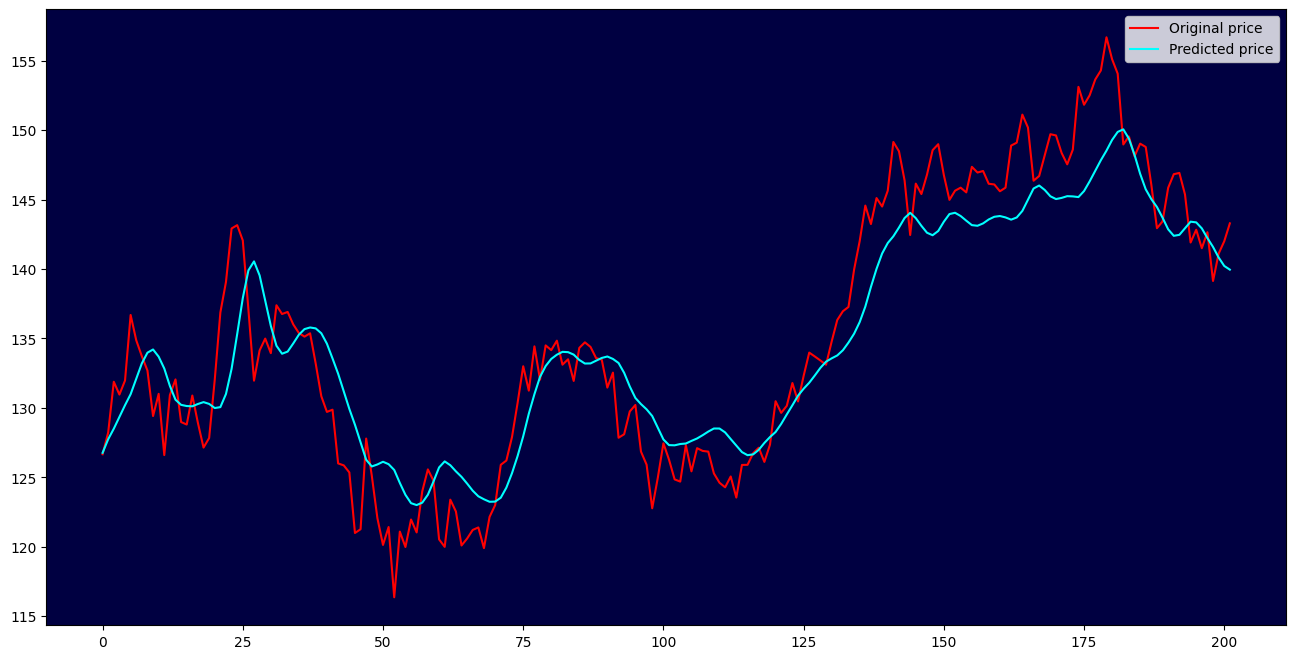

In [18]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictions, color='cyan', label='Predicted price')
plt.legend()